In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
# a library used to draw tree like diagram of how a Value is obatained, not important. 

from graphviz import Digraph

def trace(root):
    # builds a set of all node and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for many value in graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node for it 
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)   

    return dot


In [3]:
# the feeling of derivatives : the effect of changing the varibale a little to the function value
h = 0.0001

# input
a = 2
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print("slope",(d2-d1)/h)

slope 0.9999999999976694


In [236]:
# customized data structure that stores the info for each node in the nn

class Value:

    def __init__(self,data,_childeren=(),_op="",label=""):
        
        self.data = data
        self.grad = 0.0 # default assumes that changing this variable does not affect the loss fucntion
        self._backward = lambda:None # function how to calculate the gradient of connected nodes, by default empty
        self._prev = set(_childeren) # tuple 转 set
        self._op = _op
        self.label =label 
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # convert other into Value instance if it is not
        # so number dtypes support this operation as well
        other = other if isinstance(other,Value) else Value(other) 
        out = Value(self.data + other.data,(self,other),"+")

        # apply chain rule to update grads for addition operation
        # using addition to grad
        # so that if a node is connected to multiple other nodes
        # the grad would not be overwritten according to reversed topological oder           
        # rather the grad is accumulated for different connections
        # according to the partial derivative chain rules
        # remember to zero grad in each bp iteration later
        
        # for example, if w is connected to a and b            
        # dL/dw = dL/da * da/dw + dL/db * db/dw
        def _backward():
            self.grad += out.grad * 1.0 
            other.grad += out.grad * 1.0
        # out._backward 会将gradient计算好赋值给其子结点
        out._backward = _backward
        
        return out

    def __radd__(self,other):
        # a = Value(1)
        # 2 + a does not work for add, 2.value does not exist
        # Python would seek reversed add (radd), the sequence of variable is switched
        # where self = a, and other = 2
        return self+other
    
    def __neg__(self):
        # negation
        return self * -1
        
    def __sub__(self,other):
        # self - other
        return self + (-other)

    def __rsub__(self,other):
        return self +(-other)
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),"*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out

    def __rmul__(self,other):  
        # if written as other * self and other is not a Value instance
        # python check if there is reverse mul 
        # rmul would basically call mul
        return self * other

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers"
        out = Value(self.data**other,(self,), f'** {other}')
        def _backward():
            self.grad = other* (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        # self / other
        return self* other**-1
    

    def exp(self):
        out = Value(math.exp(self.data),(self,),'exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        out = Value(t,(self, ),"tanh")
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        # official backward func of all nodes before the self nodes
        # topological sort
        # to ensure that bp is done only when all nodes after one node has been bped
        # build an array that expands the network from left to right 
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)  # ;print(topo)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# Simple network setting up, Forward Propagation
a = Value(2,label="a")
b = Value(-3,label="b")
c = Value(10,label="c")
e = a*b; e.label = "e"
d = e+c; d.label = "d"
f = Value(-2.0,label="f")
L = d * f; L.label = "L"
d

Value(data=4)

In [5]:
# dL/dL = 1
L.grad = 1.0

# dl/df = d ; dL/dd = f
f.grad = d.data
d.grad = f.data

# dL/dc = dL/dd * dd/dc ; dL/de = dL/dd * dd/de
c.grad = d.grad * 1
e.grad = d.grad * 1

# dL/da = dL/de * de/da ; dL/db = dL/de * de/db
#           ^       ^
#      recursive    ^
#                   local
a.grad = e.grad * b.data
b.grad = e.grad * a.data

# back - propagation  = local gradient * recursive gradient
# recursively go through each nodes, and utilize chain rule

In [6]:
# Manually updating the variables to make L increase
# Using the grdient obtaining

# Controlling leaf nodes
# e is an obatined node, so it is not adjusted
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Forword propagation to update values
e = a * b
d = e + c
L = f * d
print(L.data)

-7.286496


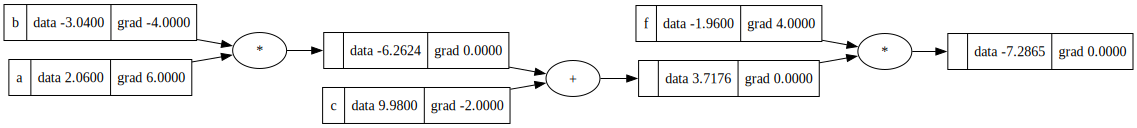

In [7]:
draw_dot(L)

In [8]:
def lol():
    # Manually calculate the gradient value of the simple network
    
    h = 0.001

    # Initial Value of L
    a = Value(2,label="a")
    b = Value(-3,label="b")
    c = Value(10,label="c")
    e = a*b; e.label = "e"
    d = e+c; d.label = "d"
    f = Value(-2.0,label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    # Updated of L.data Value 
    # if a variable has changed a little by the amount of h
    a = Value(2 ,label="a")
    b = Value(-3 + h,label="b")
    c = Value(10,label="c")
    e = a*b; e.label = "e" 
    d = e+c; d.label = "d"
    f = Value(-2.0,label="f")
    L = d * f; L.label = "L"
    L2 = L.data 

    print((L2-L1)/h)

lol()

-3.9999999999995595


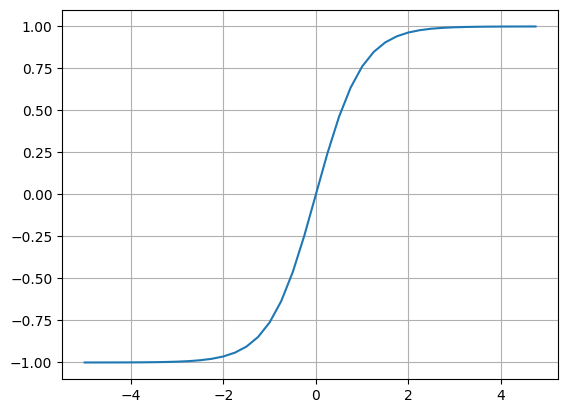

In [10]:
# tanh activation functions
plt.plot(np.arange(-5,5,0.25),np.tanh(np.arange(-5,5,0.25))); plt.grid()

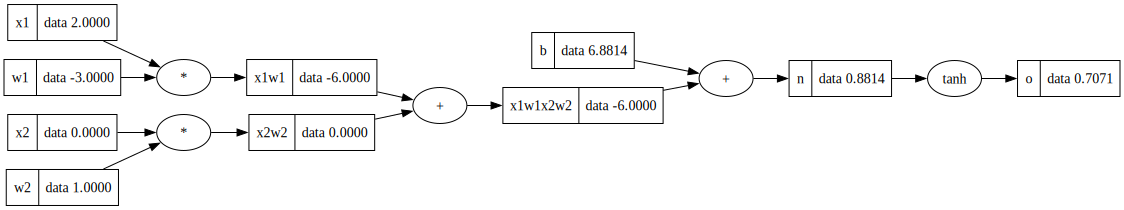

In [238]:
# a single neruon - initiation

# inputs x1, x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weight w1, w2 and bias b
w1 = Value(-3.0,label='w1')
w2 =  Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b')

# Manual Inference
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

In [64]:
# manual back - propagation 

o.grad = 1.0 # do/do
n.grad = 1 - o.data ** 2 # do/dn , equation for dtanh(x)/dx

x1w1x2w2.grad = n.grad * 1.0
b.grad = n.grad * 1.0

x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data # the input x2 is 0, meaning that any changes to w2 has no effe t on the final result

In [37]:
# automatic calculation for gradient descent,using lambda equation
o.grad = 1.0
o._backward()
n._backward()
b._backward() # as a leaf node the lambda for it is initialized as None, so no effect
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [65]:
# Completely automatic grad for all nodes 
o.backward()

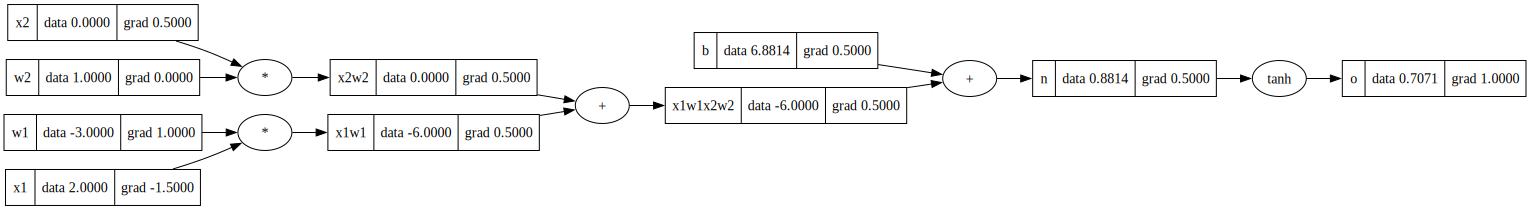

In [66]:
draw_dot(o)

In [63]:
a = Value(4)
b = Value(2)

Value(data=2)

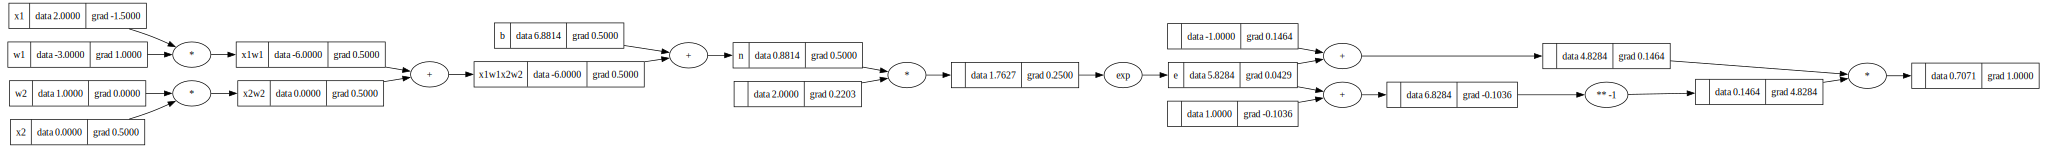

In [70]:
# a single neruon - initiation

# inputs x1, x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weight w1, w2 and bias b
w1 = Value(-3.0,label='w1')
w2 =  Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b')

# Manual Inference
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

# separate tanh into smaller operations which are alos implemented
# this should get the exact same results as before
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.labele = 'o'

o.backward()

draw_dot(o)

# Implement via PyTorch #

In [72]:
import torch

In [74]:
# leaf nodes / inputs do not require gradient, so need to manually set as True in this case
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print("o",o.data.item())  # Inference
o.backward() # bp
print("---")
# .item() to get the single item out of the tensor
print("x1",x1.grad.item())
print("w1",w1.grad.item())
print("x2",x2.grad.item())
print("w2",w2.grad.item())

#pytorch has the same results as autograd

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
o 0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


# Implement MLP #

In [231]:
class Neuron:
    def __init__(self,nin):
        # np.random.uniform(a,b)  randomly pick from [a,b) of a uniform distribution
        # initialize with multiple values
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)] # initialize all weights, dim = nin
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self,x):
        # calculate the output of this nueron
        # call is when using neuron(), python would directly utilizes this function
        
        # zip(self.w,x) combines array w and x pairwise together
        # act = sum(wi* xi for wi,xi in zip(self.w,x)) + self.b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) # to start the sum from b rather than 0
        out = act.tanh()
        return out

    def parameters(self):
        # returns the parameters of a neruon
        return self.w + [self.b]
        

class Layer: 
    def __init__(self,nin,nout):
        # initialize number of neurons = nout, fully conncected to nin
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        # obtain the outputs of all neurons
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # return all parameters in a layer
        return [p for neruon in self.neurons for p in neruon.parameters()]

        #Equivalent to upward codes
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neruon.parameters()) # extending the array, no change to dim
        # return params

class MLP:
    def __init__(self,nin,nouts):
        # taking a list nouts -- the number of outputs in each layer & len tells layer number
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # initialize all layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        # returns the parameters in the nn
        return [p for layer in self.layers for p in layer.parameters()]


In [232]:
# x = [2,3,-1]
# n = Neuron(3)
# n(x)
# p = Layer(3,2)
# p(x)
nn = MLP(3,[4,4,1]) # 3 inputs, 2 hidden layers each of 4 outputs, 1 output
# nn(x)

In [233]:
# data set for binary classification problem
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1,],
    [1,1,-1]
]
ys = [1,-1,-1,1] # desired output

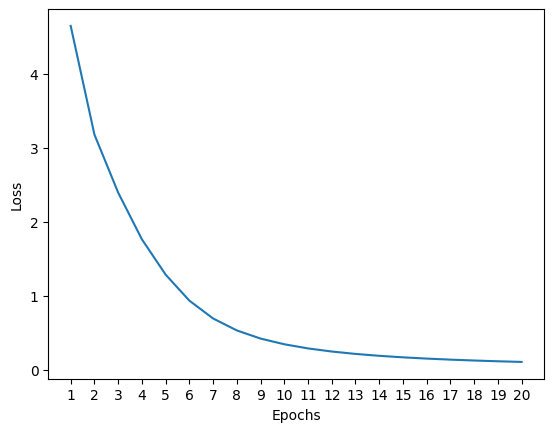

In [234]:
# Gradient Descent
epoch = []
Loss = []
for k in range(20):
    #inference
    ypred = [nn(x) for x in xs]
    loss = sum([(yout-t)**2 for t,yout in zip(ys,ypred)]) ; loss.label = 'Loss'
    
    #back-propagation
    for p in nn.parameters():
        p.grad = 0  # reset gradients to zero at each bp iteration, since += is used when upadting grads
    loss.backward()

    #gradient descent
    for p in nn.parameters():
        p.data -= 0.05 * p.grad
    epoch.append(k+1)
    Loss.append(loss.data)

plt.plot(epoch,Loss)
plt.xticks(epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [217]:
print(ypred)

[Value(data=0.9112686195232549), Value(data=-0.8600643878649723), Value(data=-0.8890509625297024), Value(data=0.8369181499791233)]


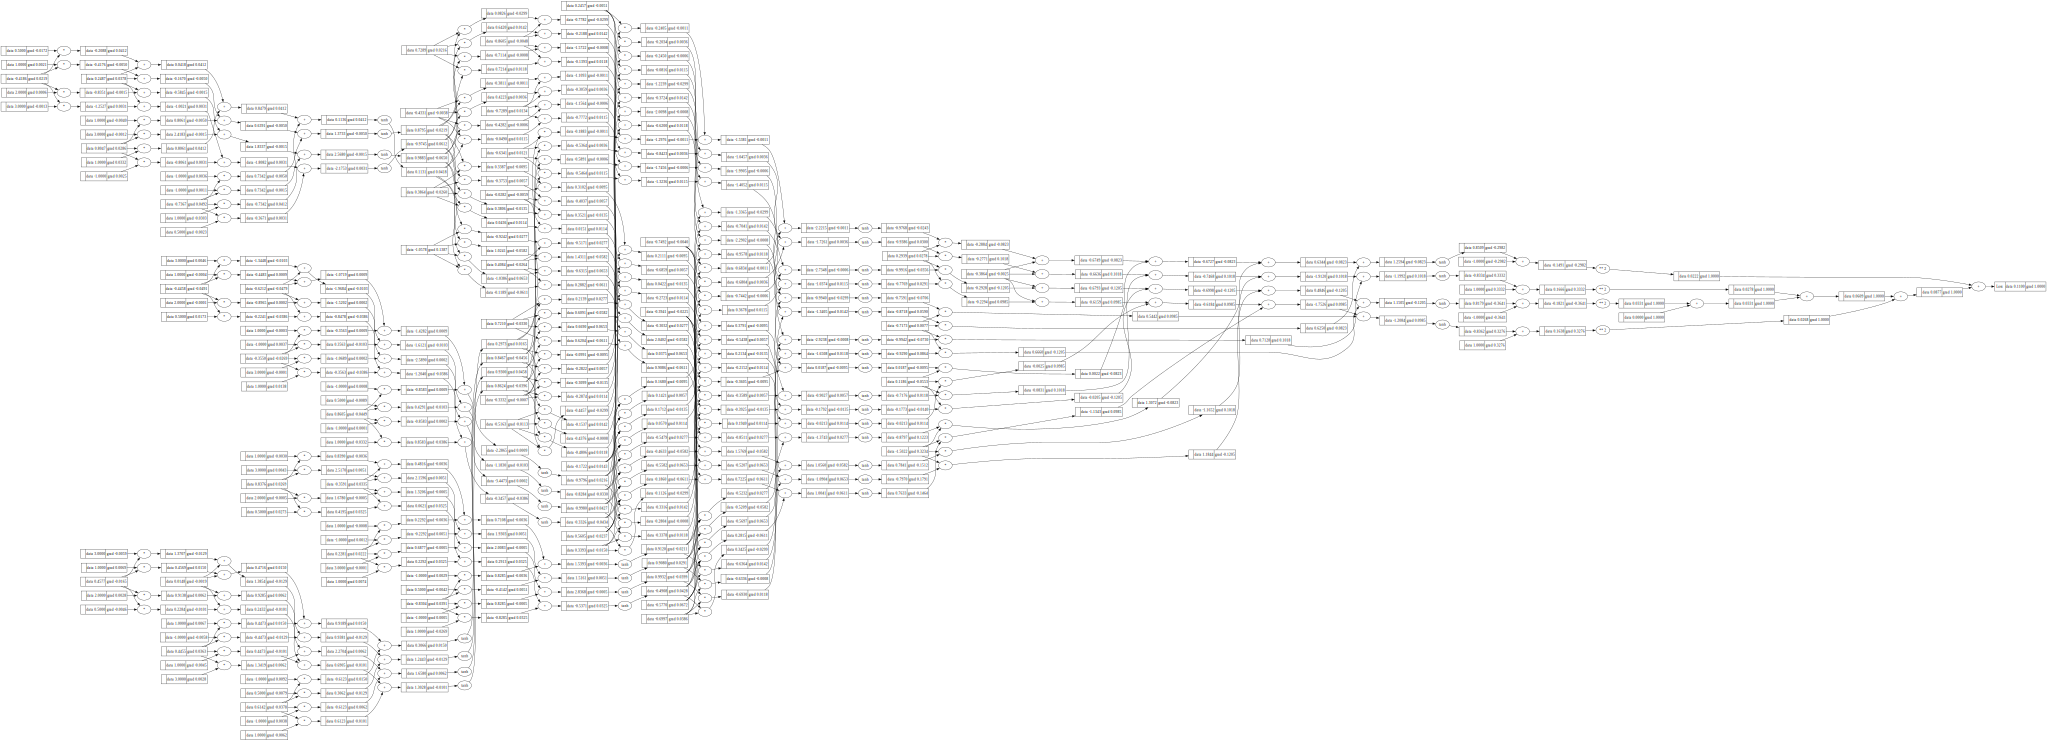

In [235]:
draw_dot(loss)